# 基于机器学习可解释性分析

In [16]:
# !pip install imbalanced-learn -i https://pypi.tuna.tsinghua.edu.cn/simple
# !pip install shap -i https://pypi.tuna.tsinghua.edu.cn/simple


In [1]:
# 忽视警告，
import warnings
warnings.filterwarnings('ignore')

# 认识数据

In [2]:
import pandas as pd

# 使用pandas的read_csv函数读取CSV文件
data = pd.read_csv('train.csv')

# # 随机打乱数据集，这一步的操作是可选的，类似于把练习题不断更改顺序，防止电脑学习到固定的顺序，这一步是可选的
# random_seed = 77
# data = data.sample(frac=1, random_state=random_seed)

# 显示前几行数据，以确认数据已正确加载

data.head()

,user_id,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,1374,58,No,Travel_Rarely,605,Sales,21,3,Life Sciences,1,...,3,80,1,29,2,2,1,0,0,0
1,1092,45,No,Travel_Rarely,950,Research & Development,28,3,Technical Degree,1,...,4,80,1,8,3,3,5,4,0,3
2,768,40,No,Travel_Rarely,300,Sales,26,3,Marketing,1,...,2,80,1,8,3,2,7,7,7,5
3,569,36,No,Non-Travel,1434,Sales,8,4,Life Sciences,1,...,2,80,0,10,1,3,10,7,0,9
4,911,25,Yes,Travel_Frequently,599,Sales,24,1,Life Sciences,1,...,4,80,0,1,4,3,1,0,1,0


显然id列是噪声列，可以删除

In [5]:
data = data.drop(columns=['user_id'])
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,58,No,Travel_Rarely,605,Sales,21,3,Life Sciences,1,1938,...,3,80,1,29,2,2,1,0,0,0
1,45,No,Travel_Rarely,950,Research & Development,28,3,Technical Degree,1,1546,...,4,80,1,8,3,3,5,4,0,3
2,40,No,Travel_Rarely,300,Sales,26,3,Marketing,1,1066,...,2,80,1,8,3,2,7,7,7,5
3,36,No,Non-Travel,1434,Sales,8,4,Life Sciences,1,789,...,2,80,0,10,1,3,10,7,0,9
4,25,Yes,Travel_Frequently,599,Sales,24,1,Life Sciences,1,1273,...,4,80,0,1,4,3,1,0,1,0


可以明显发现id其实是一个冗余的信息，其实可以删除，但是由于很多模型对于id本身并不敏感，在最后的解释性上可以看到id这一列几乎没有影响


In [6]:
data.shape # 查看数据集的行数和列数

(1176, 35)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176 entries, 0 to 1175
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1176 non-null   int64 
 1   Attrition                 1176 non-null   object
 2   BusinessTravel            1176 non-null   object
 3   DailyRate                 1176 non-null   int64 
 4   Department                1176 non-null   object
 5   DistanceFromHome          1176 non-null   int64 
 6   Education                 1176 non-null   int64 
 7   EducationField            1176 non-null   object
 8   EmployeeCount             1176 non-null   int64 
 9   EmployeeNumber            1176 non-null   int64 
 10  EnvironmentSatisfaction   1176 non-null   int64 
 11  Gender                    1176 non-null   object
 12  HourlyRate                1176 non-null   int64 
 13  JobInvolvement            1176 non-null   int64 
 14  JobLevel                

### 数据集信息

- **数据集类型**: `pandas.core.frame.DataFrame`
- **总行数**: 7500 条记录
- **索引范围**: 从 2125 到 6871
- **总列数**: 18 列

---

### 列信息

| 列名                             | 非空值数量 | 数据类型   | 说明                                                                 |
|----------------------------------|------------|------------|----------------------------------------------------------------------|
| **Id**                           | 7500       | `int64`    | 每条记录的唯一标识符。                                               |
| **Home Ownership**               | 7500       | `object`   | 房屋所有权状态（可能是分类变量，如 "Own", "Rent" 等）。              |
| **Annual Income**                | 5943       | `float64`  | 年收入（有缺失值，7500 条记录中只有 5943 条有值）。                  |
| **Years in current job**         | 7129       | `object`   | 在当前工作的年限（可能是分类变量，如 "<1 year", "5+ years" 等）。    |
| **Tax Liens**                    | 7500       | `float64`  | 税务留置权数量（无缺失值）。                                         |
| **Number of Open Accounts**      | 7500       | `float64`  | 当前开放的账户数量（无缺失值）。                                     |
| **Years of Credit History**      | 7500       | `float64`  | 信用历史年限（无缺失值）。                                           |
| **Maximum Open Credit**          | 7500       | `float64`  | 最大开放信用额度（无缺失值）。                                       |
| **Number of Credit Problems**    | 7500       | `float64`  | 信用问题数量（无缺失值）。                                           |
| **Months since last delinquent** | 3419       | `float64`  | 上次违约以来的月数（有较多缺失值，7500 条记录中只有 3419 条有值）。 |
| **Bankruptcies**                 | 7486       | `float64`  | 破产次数（有少量缺失值，7500 条记录中只有 7486 条有值）。            |
| **Purpose**                      | 7500       | `object`   | 贷款目的（可能是分类变量，如 "Debt Consolidation", "Home Improvement" 等）。 |
| **Term**                         | 7500       | `object`   | 贷款期限（可能是分类变量，如 "Short Term", "Long Term" 等）。        |
| **Current Loan Amount**          | 7500       | `float64`  | 当前贷款金额（无缺失值）。                                           |
| **Current Credit Balance**       | 7500       | `float64`  | 当前信用余额（无缺失值）。                                           |
| **Monthly Debt**                 | 7500       | `float64`  | 月债务（无缺失值）。                                                 |
| **Credit Score**                 | 5943       | `float64`  | 信用评分（有缺失值，7500 条记录中只有 5943 条有值）。                |
| **Credit Default**               | 7500       | `int64`    | 是否违约（目标变量，可能是 0 或 1，表示是否违约）。                  |

---

### 数据类型分布

- **数值型 (`float64` 和 `int64`)**:
  - 共 14 列，包括 `Id`, `Annual Income`, `Tax Liens`, `Number of Open Accounts`, `Years of Credit History`, `Maximum Open Credit`, `Number of Credit Problems`, `Months since last delinquent`, `Bankruptcies`, `Current Loan Amount`, `Current Credit Balance`, `Monthly Debt`, `Credit Score`, `Credit Default`。
- **对象型 (`object`)**:
  - 共 4 列，包括 `Home Ownership`, `Years in current job`, `Purpose`, `Term`。这些列通常是分类变量或文本数据。

---

### 缺失值情况

- **无缺失值的列**:
  - `Id`, `Home Ownership`, `Tax Liens`, `Number of Open Accounts`, `Years of Credit History`, `Maximum Open Credit`, `Number of Credit Problems`, `Purpose`, `Term`, `Current Loan Amount`, `Current Credit Balance`, `Monthly Debt`, `Credit Default`。
- **有缺失值的列**:
  - `Annual Income`: 缺失 1557 条记录。
  - `Years in current job`: 缺失 371 条记录。
  - `Months since last delinquent`: 缺失 4081 条记录。
  - `Bankruptcies`: 缺失 14 条记录。
  - `Credit Score`: 缺失 1557 条记录。

---

### 内存使用

- 内存占用: 1.1+ MB

In [8]:
data.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1176.000000,1176.000000,1176.000000,1176.000000,1176.0,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,...,1176.000000,1176.0,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.00000,1176.000000,1176.000000
mean,36.805272,802.033163,9.159864,2.918367,1.0,1026.960034,2.750850,65.130102,2.724490,2.055272,...,2.714286,80.0,0.805272,11.161565,2.767007,2.764456,6.982143,4.19898,2.160714,4.098639
std,9.065549,405.946729,8.137224,1.009809,0.0,594.763609,1.096221,20.294326,0.715027,1.106040,...,1.080583,0.0,0.865611,7.747576,1.250756,0.713251,6.094338,3.63124,3.208052,3.564190
min,18.000000,104.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000
25%,30.000000,463.500000,2.000000,2.000000,1.0,498.750000,2.000000,48.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.00000,0.000000,2.000000
50%,36.000000,805.500000,7.000000,3.000000,1.0,1031.000000,3.000000,65.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.00000,1.000000,3.000000
75%,42.250000,1162.000000,14.000000,4.000000,1.0,1555.250000,4.000000,82.250000,3.000000,3.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.00000,2.250000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.00000,15.000000,17.000000


# 认识问题

In [10]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder # preprocessing预处理模块 - 用于特征标准化、独热编码和数值编码
from sklearn.model_selection import train_test_split # model_selection 模型选择 - 用于将数据集划分为训练集和测试集


# 分离特征数据和标签数据
X = data.drop(['Attrition'], axis=1)  # 特征数据 除了标签以外的列读到x里面
y = data['Attrition']  # 标签数据

y

0        No
1        No
2        No
3        No
4       Yes
       ... 
1171     No
1172     No
1173     No
1174     No
1175     No
Name: Attrition, Length: 1176, dtype: object

In [11]:
# 查看标签数据的分布
y.value_counts() # 0有5387个，1有2113个

Attrition
No     988
Yes    188
Name: count, dtype: int64

# 数据预处理

In [ ]:
# 数字
digital_cols = ['Age', 'DailyRate', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike',                
'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
# 分类
category_cols = ['BusinessTravel', 'Department',  'Education', 'EducationField',                
'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'JobInvolvement', 'JobLevel','DistanceFromHome',                
'JobRole', 'JobSatisfaction', 'MaritalStatus', 'Over18', 'OverTime',                
'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'PerformanceRating', 'TrainingTimesLastYear','WorkLifeBalance' ]

In [ ]:
# 填补缺失值，使用众数
for column in X.columns:
    if X[column].dtype in ['float64', 'int64']:
        mode = X[column].mode()[0] # 计算计算该列的众数
        X[column].fillna(mode, inplace=True) # 使用众数填补缺失值


# 分离连续特征和离散特征
continuous_features = X.select_dtypes(include=['float64', 'int64']).columns # 连续
discrete_features = X.select_dtypes(include=['object']).columns # 离散
print(continuous_features)
print(discrete_features)

# 连续特征标准化
scaler = StandardScaler()
X_continuous = scaler.fit_transform(X[continuous_features]) # 将连续特征进行标准化，均值为0，方差为1
print(X_continuous)

# 离散特征编码
# 对于有序离散特征使用数值编码
label_encoder = LabelEncoder()
# 假设 'Years in current job' 是有序离散特征，将其编码为数值
X['Education'] = label_encoder.fit_transform(X['Education'])


# 对于无序离散特征使用独热编码
onehot_encoder = OneHotEncoder()
X_discrete = onehot_encoder.fit_transform(X[discrete_features.drop('Education')])


# 组合处理后的连续特征和离散特征
X = pd.concat([pd.DataFrame(X_continuous, columns=continuous_features),
pd.DataFrame(X_discrete.toarray(), columns=onehot_encoder.get_feature_names_out(discrete_features.drop('Education')))], axis=1)


# 使用 train_test_split 函数按照 8:2 的比例划分数据集
# test_size=0.2 表示 20%的数据用作测试集，即验证集。
# random_state 是一个随机数种子，确保每次划分的结果相同，便于复现结果。
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome',
       'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike',
       'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')
Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'Over18', 'OverTime'],
      dtype='object')
[[ 2.3389367  -0.48557354  1.45567735 ... -1.15684058 -0.67381506
  -1.15043886]
 [ 0.9043263   0.36465323  2.31628752 ... -0.05481991 -0.67381506
  -0.3083749 ]
 [ 0.35255307 -1.23722329  2.0703989  ...  0.7716956   1.50912298
   0.25300108]
 ...
 [ 0.68361701  0.92900666 -0.88

In [65]:
# 打印处理后的数据集信息
X_train.info()
# X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6000 entries, 4664 to 7270
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 6000 non-null   float64
 1   Tax Liens                     6000 non-null   float64
 2   Number of Open Accounts       6000 non-null   float64
 3   Years of Credit History       6000 non-null   float64
 4   Maximum Open Credit           6000 non-null   float64
 5   Number of Credit Problems     6000 non-null   float64
 6   Months since last delinquent  6000 non-null   float64
 7   Bankruptcies                  6000 non-null   float64
 8   Current Loan Amount           6000 non-null   float64
 9   Current Credit Balance        6000 non-null   float64
 10  Monthly Debt                  6000 non-null   float64
 11  Credit Score                  6000 non-null   float64
 12  Home Ownership_Have Mortgage  6000 non-null   float64
 13  Home 

In [66]:
y_train.value_counts()

Credit Default
0    4328
1    1672
Name: count, dtype: int64

In [67]:
# 对训练集进行过采样

from imblearn.over_sampling import SMOTE

# 使用 SMOTE 进行过采样,并赋值给自己
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [68]:
y_train.value_counts()

Credit Default
0    4328
1    4328
Name: count, dtype: int64

In [69]:
X_train.info()
# X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8656 entries, 0 to 8655
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 8656 non-null   float64
 1   Tax Liens                     8656 non-null   float64
 2   Number of Open Accounts       8656 non-null   float64
 3   Years of Credit History       8656 non-null   float64
 4   Maximum Open Credit           8656 non-null   float64
 5   Number of Credit Problems     8656 non-null   float64
 6   Months since last delinquent  8656 non-null   float64
 7   Bankruptcies                  8656 non-null   float64
 8   Current Loan Amount           8656 non-null   float64
 9   Current Credit Balance        8656 non-null   float64
 10  Monthly Debt                  8656 non-null   float64
 11  Credit Score                  8656 non-null   float64
 12  Home Ownership_Have Mortgage  8656 non-null   float64
 13  Hom

# 开始建模和训练

## 错误案例：把线性回归用来做分类问题

线性回归只能做回归问题，逻辑回归只能做分类问题
roc曲线是用阈值来画的，所以可以看到结果，之前没有打印混淆矩阵，差点就被迷惑了

In [70]:
# 导入所需的库
import pandas as pd  # 用于数据处理和分析
import numpy as np  # 用于数值计算
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder  # 用于数据预处理
from sklearn.model_selection import train_test_split, GridSearchCV  # 用于数据集划分和超参数调优
from sklearn.linear_model import LinearRegression  # 线性回归模型
from sklearn.linear_model import LogisticRegression  # 逻辑回归模型
from sklearn.svm import SVC  # 支持向量机分类模型
from sklearn.naive_bayes import GaussianNB  # 高斯朴素贝叶斯模型
from sklearn.ensemble import RandomForestClassifier  # 随机森林分类模型
import xgboost as xgb  # XGBoost模型
import lightgbm as lgb  # LightGBM模型
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, classification_report  # 用于模型评估
import warnings
# 忽略所有警告
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt # 绘图

print("Linear Regression:")
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
# conf_matrix = confusion_matrix(y_test, y_pred_lr)
# y_pred_lr
print("AUC: ", roc_auc_score(y_test, y_pred_lr)) # 错误的

Linear Regression:
AUC:  0.7706966954235266


In [71]:
print(y_test.value_counts())

Credit Default
0    1059
1     441
Name: count, dtype: int64


## 1逻辑回归

In [85]:
# 逻辑回归用于分类问题，不调参
from sklearn.metrics import f1_score
print("Logistic Regression:")
lr = LogisticRegression() # 实例化逻辑回归模型
lr.fit(X_train, y_train) # 训练模型
y_pred_lr = lr.predict(X_test) # 预测
print("Accuracy: ", accuracy_score(y_test, y_pred_lr))

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr)) # 混淆矩阵
print("Classification Report:\n", classification_report(y_test, y_pred_lr)) # 分类报告
y_pred_proba = lr.predict_proba(X_test)[:, 1]
y_pred=lr.predict(X_test)
print("AUC: ", roc_auc_score(y_test, y_pred_proba)) # AUC
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
# precision：精确率，
# recall：召回率，
# f1-score：F1值，混合了精确率和召回率的一个指标
# support：样本个数

# 最后AUC是0.77


Logistic Regression:
Accuracy:  0.6873333333333334
Confusion Matrix:
 [[741 318]
 [151 290]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.70      0.76      1059
           1       0.48      0.66      0.55       441

    accuracy                           0.69      1500
   macro avg       0.65      0.68      0.66      1500
weighted avg       0.73      0.69      0.70      1500

AUC:  0.7714953781323672
F1 Score: 0.5529


In [34]:
y_pred_lr

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# 假设你已经有了数据集 X 和标签 y
# X 是特征矩阵，y 是标签向量

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 定义逻辑回归模型
lr = LogisticRegression()

# 定义参数网格
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # 正则化强度的倒数
    'penalty': ['l1', 'l2'],       # 正则化类型
    'solver': ['liblinear']        # 优化算法（liblinear 支持 l1 和 l2）
}

# 初始化网格搜索
grid_search = GridSearchCV(
    estimator=lr,  # 模型
    param_grid=param_grid,  # 参数网格
    cv=5,  # 五折交叉验证 - 结果更加可信
    scoring='roc_auc',  # 使用 AUC 作为评估指标
    n_jobs=-1  # 使用所有可用的CPU核心
)

# 在训练集上执行网格搜索
grid_search.fit(X_train, y_train)

# 输出最佳参数
print("最佳参数组合:", grid_search.best_params_)

# 使用最佳参数训练模型
best_lr = grid_search.best_estimator_

# 在测试集上进行预测
y_pred_lr = best_lr.predict(X_test)

# 输出混淆矩阵
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

# 输出分类报告
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

# 输出 AUC
y_pred_proba = best_lr.predict_proba(X_test)[:, 1]  # 获取正类的概率 ：表示所有行，1表示第二列
print("测试集 AUC: ", roc_auc_score(y_test, y_pred_proba))
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")

最佳参数组合: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Confusion Matrix:
 [[1038   21]
 [ 335  106]]
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.98      0.85      1059
           1       0.83      0.24      0.37       441

    accuracy                           0.76      1500
   macro avg       0.80      0.61      0.61      1500
weighted avg       0.78      0.76      0.71      1500

测试集 AUC:  0.7704997012969494
F1 Score: 0.5529


In [36]:
print("y_test:真实的标签")
print(y_test)
print("\n\n")
print("y_pred_lr:预测的标签")
print(y_pred_lr)
print("\n\n")
print("y_pred_proba:")
print(y_pred_proba)
print("\n\n")
print("best_lr.predict_proba(X_test)")
print(best_lr.predict_proba(X_test))

y_test:真实的标签
970     1
6279    0
1859    0
6803    0
6305    0
       ..
6434    0
5441    0
2760    0
4588    1
2669    0
Name: Credit Default, Length: 1500, dtype: int64



y_pred_lr:预测的标签
[1 0 0 ... 0 1 0]



y_pred_proba:
[0.99692694 0.14110135 0.28045292 ... 0.30375761 0.9982598  0.48385158]



best_lr.predict_proba(X_test)
[[0.00307306 0.99692694]
 [0.85889865 0.14110135]
 [0.71954708 0.28045292]
 ...
 [0.69624239 0.30375761]
 [0.0017402  0.9982598 ]
 [0.51614842 0.48385158]]


In [37]:
# 计算混淆矩阵 -- 好看一点
# cm = confusion_matrix(y_test, y_pred_lr)

# # 使用 seaborn 绘制彩色混淆矩阵
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
#             xticklabels=['Predicted 0', 'Predicted 1'], 
#             yticklabels=['Actual 0', 'Actual 1'])
# plt.title("Confusion Matrix")
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.show()

## SVM

这个算法解释性很差，而且速度很慢，所以不推荐使用

In [38]:
# 定义 SVM 模型（使用默认参数）
svm = SVC(probability=True, random_state=42)  # 启用概率估计

# 训练模型
svm.fit(X_train, y_train)

# 在测试集上进行预测
y_pred_proba = svm.predict_proba(X_test)[:, 1]  # 获取正类的概率

# 输出测试集 AUC
print("测试集 AUC: ", roc_auc_score(y_test, y_pred_proba))

测试集 AUC:  0.7331179245384021


In [42]:
# 定义 SVM 模型
svm = SVC(probability=True, random_state=42)  # 启用概率估计

# 定义参数网格
param_grid = {
    'C': [0.1, 1, 10],  # 正则化参数
    'kernel': ['linear', 'rbf'],  # 核函数
    'gamma': ['scale', 'auto']  # 核函数的系数
}

# 初始化网格搜索
grid_search = GridSearchCV(
    estimator=svm,  # 模型
    param_grid=param_grid,  # 参数网格
    cv=5,  # 五折交叉验证
    scoring='roc_auc',  # 使用 AUC 作为评估指标
    n_jobs=-1  # 使用所有可用的CPU核心
)

# 在训练集上执行网格搜索
grid_search.fit(X_train, y_train)

# 输出最佳参数
print("最佳参数组合:", grid_search.best_params_)

# 使用最佳参数训练模型
best_svm = grid_search.best_estimator_

# 在测试集上进行预测
y_pred_svm = best_svm.predict_proba(X_test)[:, 1]  # 获取正类的概率

# 输出测试集 AUC
print("测试集 AUC: ", roc_auc_score(y_test, y_pred_svm))

最佳参数组合: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
测试集 AUC:  0.7444900528672282



## CatBoostClassifier

In [73]:
CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]

from catboost import CatBoostClassifier, CatBoostRegressor, Pool
# model_catb = CatBoostClassifier(silent=True, random_state=21,cat_features=CAT_FEATURE_NAMES,
#                                      one_hot_max_size=3,
#                                      class_weights=[1, disbalance])
model_catb = CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred=model_catb.predict(X_train)
y_pred_cat=model_catb.predict_proba(X_test)[:, 1]
y_pred_lr = model_catb.predict(X_test)

# 输出混淆矩阵
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

# 输出分类报告
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

# 输出测试集 AUC
print("测试集 AUC: ", roc_auc_score(y_test, y_pred_svm))

# def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
#     print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
#     print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
#     print('CONFUSION MATRIX\n')
#     print(pd.crosstab(y_test_true, y_test_pred))

# def evaluate_preds(model, X_train, X_test, y_train, y_test):
#     y_train_pred = model.predict(X_train)
#     y_test_pred = model.predict(X_test)

#     get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

# evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

Confusion Matrix:
 [[926 133]
 [253 188]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.87      0.83      1059
           1       0.59      0.43      0.49       441

    accuracy                           0.74      1500
   macro avg       0.69      0.65      0.66      1500
weighted avg       0.73      0.74      0.73      1500

测试集 AUC:  0.7444900528672282


## 朴素贝叶斯

朴素贝叶斯（Naive Bayes）是一种基于概率的分类模型，通常不需要太多的超参数调优。

In [ ]:
# 朴素贝叶斯
print("Naive Bayes:")
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict_proba(X_test)[:, 1]
print("AUC: ", roc_auc_score(y_test, y_pred_nb))

Naive Bayes:
AUC:  0.743990073209013


In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score

# 假设你已经有了数据集 X 和标签 y
# X 是特征矩阵，y 是标签向量

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 定义朴素贝叶斯模型
nb = GaussianNB()

# 定义参数网格
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]  # 方差平滑参数
}

# 初始化网格搜索
grid_search = GridSearchCV(
    estimator=nb,  # 模型
    param_grid=param_grid,  # 参数网格
    cv=5,  # 五折交叉验证
    scoring='roc_auc',  # 使用 AUC 作为评估指标
    n_jobs=-1  # 使用所有可用的CPU核心
)

# 在训练集上执行网格搜索
grid_search.fit(X_train, y_train)

# 输出最佳参数
print("最佳参数组合:", grid_search.best_params_)

# 使用最佳参数训练模型
best_nb = grid_search.best_estimator_

# 在测试集上进行预测
y_pred_proba = best_nb.predict_proba(X_test)[:, 1]  # 获取正类的概率

# 输出测试集 AUC
print("测试集 AUC: ", roc_auc_score(y_test, y_pred_proba))

最佳参数组合: {'var_smoothing': 1e-05}
测试集 AUC:  0.7458861416773195


## 随机森林

In [ ]:
# 随机森林
print("Random Forest:")
rf = RandomForestClassifier()
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}
grid_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='roc_auc')
grid_rf.fit(X_train, y_train)
print("Best parameters found: ", grid_rf.best_params_)
y_pred_rf = grid_rf.predict_proba(X_test)[:, 1]
print("AUC: ", roc_auc_score(y_test, y_pred_rf))

Random Forest:
Best parameters found:  {'max_depth': 10, 'n_estimators': 200}
AUC:  0.7655641419299857


In [ ]:
# 定义随机森林模型（使用默认参数）
rf = RandomForestClassifier(random_state=42)

# 训练模型
rf.fit(X_train, y_train)

# 在测试集上进行预测
y_pred_proba = rf.predict_proba(X_test)[:, 1]  # 获取正类的概率

# 输出测试集 AUC
print(" AUC: ", roc_auc_score(y_test, y_pred_proba))

 AUC:  0.7443744258798892


In [ ]:
# 定义随机森林模型
rf = RandomForestClassifier(random_state=42)

# 定义参数网格
param_grid = {
    'n_estimators': [50, 100, 200],  # 树的数量
    'max_depth': [None, 10, 20],     # 每棵树的最大深度
    'min_samples_split': [2, 5, 10], # 分裂内部节点所需的最小样本数
    'min_samples_leaf': [1, 2, 4],   # 叶子节点所需的最小样本数
    'max_features': ['sqrt', 'log2'] # 每棵树分裂时考虑的最大特征数
}

# 初始化网格搜索
grid_search = GridSearchCV(
    estimator=rf,  # 模型
    param_grid=param_grid,  # 参数网格
    cv=5,  # 五折交叉验证
    scoring='roc_auc',  # 使用 AUC 作为评估指标
    n_jobs=-1  # 使用所有可用的CPU核心
)

# 在训练集上执行网格搜索
grid_search.fit(X_train, y_train)

# 输出最佳参数
print("最佳参数组合:", grid_search.best_params_)

# 使用最佳参数训练模型
best_rf = grid_search.best_estimator_

# 在测试集上进行预测
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]  # 获取正类的概率

# 输出测试集 AUC
print("测试集 AUC: ", roc_auc_score(y_test, y_pred_proba))

最佳参数组合: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
测试集 AUC:  0.7653200405122704


## XGBoost

In [ ]:
import xgboost as xgb  # XGBoost模型
# 定义 XGBoost 模型（使用默认参数）
xgb_model = xgb.XGBClassifier(random_state=42)

# 训练模型
xgb_model.fit(X_train, y_train)

# 在测试集上进行预测
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]  # 获取正类的概率

# 输出测试集 AUC
print("测试集 AUC: ", roc_auc_score(y_test, y_pred_proba))

测试集 AUC:  0.7443294598292575


In [84]:
import xgboost as xgb  # XGBoost模型
# 定义 XGBoost 模型
xgb_model = xgb.XGBClassifier(random_state=42)

# 定义参数网格
param_grid = {
    'max_depth': [3, 6, 9],  # 树的最大深度
    'learning_rate': [0.01, 0.1, 0.3],  # 学习率
    'n_estimators': [100, 200, 300],  # 树的数量
    'subsample': [0.8, 1.0],  # 样本采样比例
    'colsample_bytree': [0.8, 1.0]  # 特征采样比例
}

# 初始化网格搜索
grid_search = GridSearchCV(
    estimator=xgb_model,  # 模型
    param_grid=param_grid,  # 参数网格
    cv=5,  # 五折交叉验证
    scoring='roc_auc',  # 使用 AUC 作为评估指标
    n_jobs=-1  # 使用所有可用的CPU核心
)

# 在训练集上执行网格搜索
grid_search.fit(X_train, y_train)

# 输出最佳参数
print("最佳参数组合:", grid_search.best_params_)

# 使用最佳参数训练模型
best_xgb = grid_search.best_estimator_

# 在测试集上进行预测
y_pred_proba = best_xgb.predict_proba(X_test)[:, 1]  # 获取正类的概率
y_pred_lr = best_xgb.predict(X_test)

# 输出混淆矩阵
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

# 输出分类报告
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

# 输出测试集 AUC
print("测试集 AUC: ", roc_auc_score(y_test, y_pred_proba))

最佳参数组合: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 300, 'subsample': 0.8}
Confusion Matrix:
 [[907 152]
 [244 197]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.86      0.82      1059
           1       0.56      0.45      0.50       441

    accuracy                           0.74      1500
   macro avg       0.68      0.65      0.66      1500
weighted avg       0.72      0.74      0.73      1500

测试集 AUC:  0.7403189163610047


## 检查数据预处理

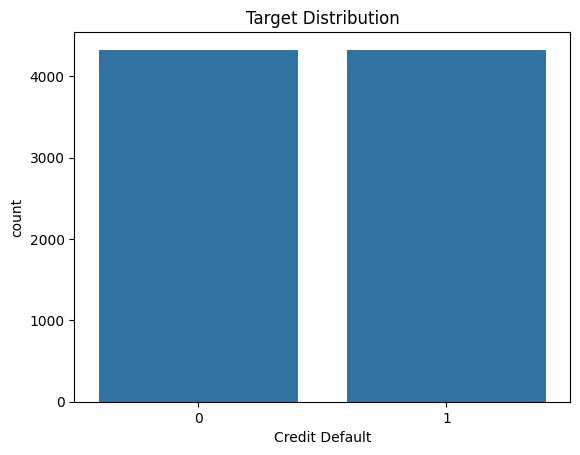

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 检查目标变量的分布
sns.countplot(x=y_train)
plt.title("Target Distribution")
plt.show()

In [ ]:
print(X_train.isnull().sum())

Annual Income                   0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Home Ownership_Have Mortgage    0
Home Ownership_Home Mortgage    0
Home Ownership_Own Home         0
Home Ownership_Rent             0
Purpose_business loan           0
Purpose_buy a car               0
Purpose_buy house               0
Purpose_debt consolidation      0
Purpose_educational expenses    0
Purpose_home improvements       0
Purpose_major purchase          0
Purpose_medical bills           0
Purpose_moving                  0
Purpose_other                   0
Purpose_renewable energy        0
Purpose_small business          0
Purpose_take a trip             0
Purpose_vacati

KeyError: 'RevolvingRatio'

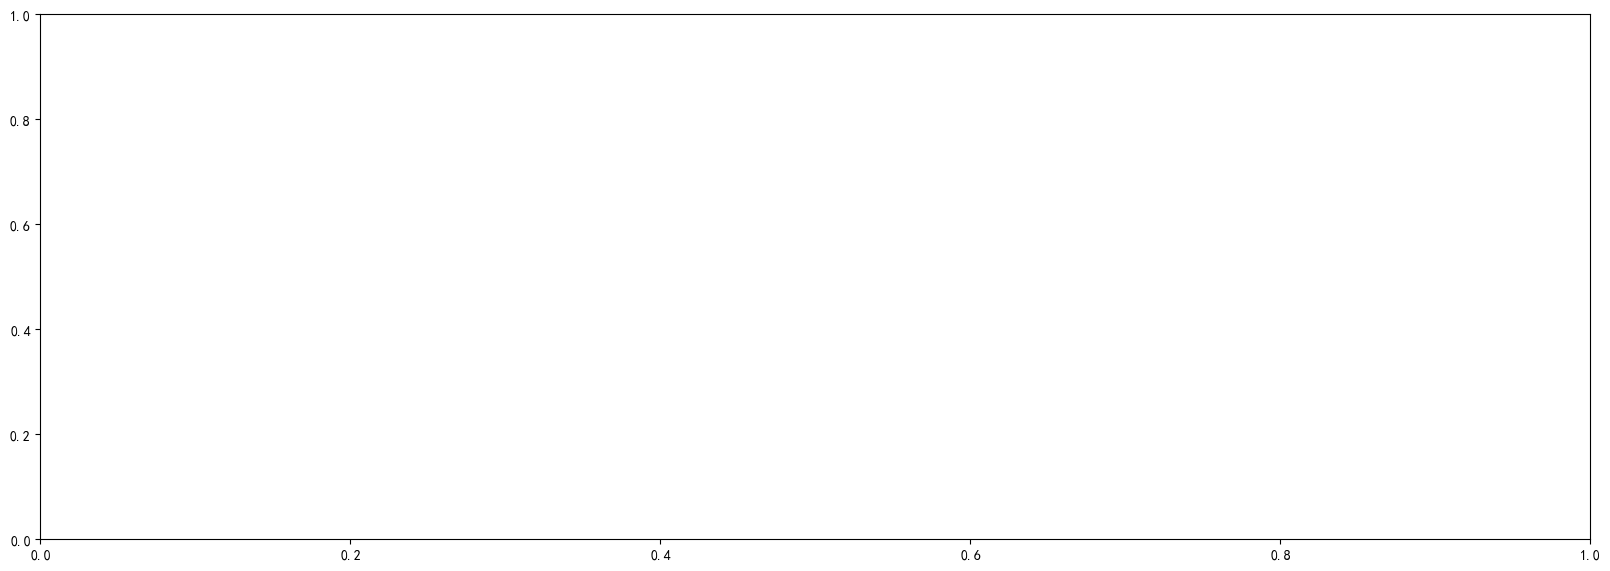

## LightGBM

利用测试集 进行无监督方法 构造聚类特征 k-means dbscan方法

In [94]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1500 entries, 970 to 2669
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 1500 non-null   float64
 1   Tax Liens                     1500 non-null   float64
 2   Number of Open Accounts       1500 non-null   float64
 3   Years of Credit History       1500 non-null   float64
 4   Maximum Open Credit           1500 non-null   float64
 5   Number of Credit Problems     1500 non-null   float64
 6   Months since last delinquent  1500 non-null   float64
 7   Bankruptcies                  1500 non-null   float64
 8   Current Loan Amount           1500 non-null   float64
 9   Current Credit Balance        1500 non-null   float64
 10  Monthly Debt                  1500 non-null   float64
 11  Credit Score                  1500 non-null   float64
 12  Home Ownership_Have Mortgage  1500 non-null   float64
 13  Home O

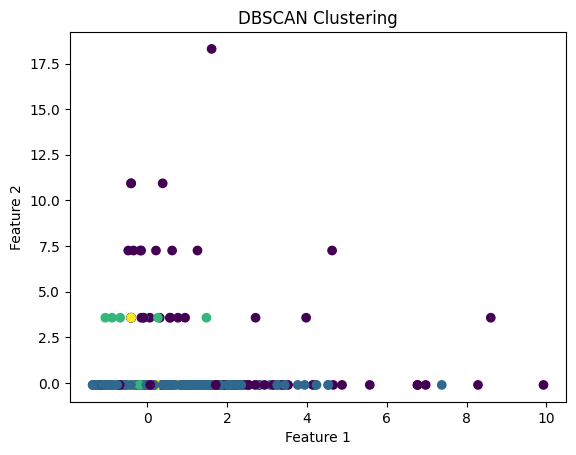

In [101]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

dbscan = DBSCAN(eps=0.3, min_samples=10)
clusters_dbscan = dbscan.fit_predict(X_test_pca)

# 可视化聚类结果（假设数据是二维的）
plt.scatter(X_test.iloc[:, 0], X_test.iloc[:, 1], c=clusters_dbscan, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('DBSCAN Clustering')
plt.show()

Unique labels: [-1  0  1  2]
Number of clusters: 3


In [106]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# 假设你已经有了数据集 X 和标签 y
# X 是特征矩阵，y 是标签向量

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 定义 LightGBM 模型（使用默认参数）
lgb_model = lgb.LGBMClassifier(random_state=42)

# 训练模型
lgb_model.fit(X_train, y_train)

# 在测试集上进行预测
y_pred_proba = lgb_model.predict_proba(X_test)[:, 1]  # 获取正类的概率
y_pred_lr = lgb_model.predict(X_test)
# 输出混淆矩阵
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

# 输出分类报告
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

# 输出测试集 AUC
print("测试集 AUC: ", roc_auc_score(y_test, y_pred_proba))
# y_pred_proba

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1672, number of negative: 4328
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1872
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.278667 -> initscore=-0.951085
[LightGBM] [Info] Start training from score -0.951085
Confusion Matrix:
 [[990  69]
 [281 160]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.93      0.85      1059
           1       0.70      0.36      0.48       441

    accuracy                           0.77      1500
   macro avg       0.74      0.65      0.66      1500
weighted avg       0.76      0.77      0.74      1500

测试集 AUC:  0.7558686049175729


In [ ]:

# 定义 LightGBM 模型 太久了 运行不出来 14h了
lgb_model = lgb.LGBMClassifier(random_state=42)

# 定义参数网格
param_grid = {
    'num_leaves': [31, 63, 127],  # 每棵树的最大叶子节点数
    'learning_rate': [0.01, 0.1, 0.3],  # 学习率
    'n_estimators': [100, 200, 300],  # 树的数量
    'max_depth': [5, 10, -1],  # 树的最大深度，-1 表示不限制
    'subsample': [0.8, 1.0],  # 样本采样比例
    'colsample_bytree': [0.8, 1.0]  # 特征采样比例
}

# 初始化网格搜索
grid_search = GridSearchCV(
    estimator=lgb_model,  # 模型
    param_grid=param_grid,  # 参数网格
    cv=5,  # 五折交叉验证
    scoring='roc_auc',  # 使用 AUC 作为评估指标
    n_jobs=-1  # 使用所有可用的CPU核心
)

# 在训练集上执行网格搜索
grid_search.fit(X_train, y_train)

# 输出最佳参数
print("最佳参数组合:", grid_search.best_params_)

# 使用最佳参数训练模型
best_lgb = grid_search.best_estimator_

# 在测试集上进行预测
y_pred_proba = best_lgb.predict_proba(X_test)[:, 1]  # 获取正类的概率

# 输出测试集 AUC
print("测试集 AUC: ", roc_auc_score(y_test, y_pred_proba))

KeyboardInterrupt: 

In [ ]:
from sklearn import metrics
from sklearn.metrics import roc_curve,roc_auc_score,precision_score,recall_score,log_loss,f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from lightgbm import LGBMClassifier
model = LGBMClassifier(boosting_type='gbdt',    #设置提升类型  rf dart
                           objective='regression',  # 定义的目标函数 binary
                           lambda_l1=0.0,
                           lambda_l2=0,
                           feature_fraction=0.8,    # 建树的特征选择比例,也是colsample_bytree，为了降低过拟合。
                           num_leaves=30,           #结果对最终效果影响较大，越大值越好，太大会出现过拟合,
                                                    # 由于lightGBM是leaves_wise生长，官方说法是要小于2^max_depth
                           bagging_fraction=0.9,    # 建树的样本采样比例，也是subsample，为了降低过拟合。
                           bagging_freq=0,          # k 意味着每 k 次迭代执行bagging，bagging的频率，0意味着没有使用bagging
                           min_child_samples=20,   #min_data_in_leaf，是一个很重要的参数，它的值取决于训练数据的样本
                                        #个数和num_leaves.将其设置的较大可以避免生成一个过深的树, 但有可能导致欠拟合。
                           learning_rate=0.1,
                           max_depth=5              #设置树深度，深度越大可能过拟合 一般4~10
                           )

model.fit(X_train, y_train)
y_test_v = model.predict(X_test)
y_test_p = model.predict_proba(X_test)[:,1]
fpr1,tpr1,threshold = roc_curve(y_test,y_test_p)
auc_value = auc(fpr1,tpr1)
print('AUC:',roc_auc_score(y_test, y_test_p))
print('KS:',max(tpr1-fpr1))

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1672, number of negative: 4328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1872
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.278667 -> initscore=-0.951085
[LightGBM] [Info] Start training from score -0.951085
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

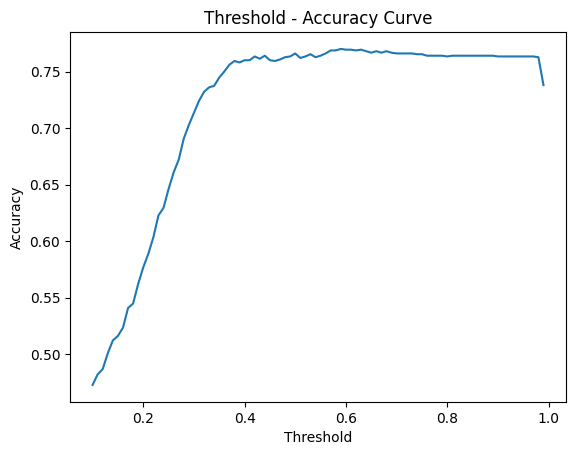

Confusion Matrix:
 [[1001   58]
 [ 293  148]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.95      0.85      1059
           1       0.72      0.34      0.46       441

    accuracy                           0.77      1500
   macro avg       0.75      0.64      0.65      1500
weighted avg       0.76      0.77      0.74      1500



In [108]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt


# 假设你已经有训练集和测试集数据 X_train, X_test, y_train, y_test
# 这里省略数据加载和划分的代码

# 定义 LightGBM 模型，使用已知的最佳参数
lgb_model = lgb.LGBMClassifier(
    colsample_bytree=0.8,
    learning_rate=0.1,
    max_depth=5,
    n_estimators=100,
    num_leaves=31,
    subsample=0.8,
    random_state=42
)

# 训练模型
lgb_model.fit(X_train, y_train)

# 在测试集上进行预测, 获得正类的概率
y_pred_proba = lgb_model.predict_proba(X_test)[:, 1]
y_pred_lr = lgb_model.predict(X_test)

# 输出测试集 AUC
print("测试集 AUC: ", roc_auc_score(y_test, y_pred_proba))

# 初始化列表用于存储不同阈值下的准确率
accuracies = []
thresholds = np.arange(0.1, 1, 0.01)
# 从0.1到1 每次增加0.01
for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int) # 将概率转换为类别
    accuracy = accuracy_score(y_test, y_pred) # 计算准确率
    accuracies.append(accuracy) # 保存准确率

# 找到最大准确率及其对应的阈值
max_accuracy_index = np.argmax(accuracies) # 找到最大准确率的索引
optimal_threshold = thresholds[max_accuracy_index] # 最佳阈值
max_accuracy = accuracies[max_accuracy_index]

print(f"最佳阈值: {optimal_threshold}")
print(f"最大准确率: {max_accuracy}")

# 绘制阈值 - 准确率曲线
plt.plot(thresholds, accuracies)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Threshold - Accuracy Curve')
plt.show()
# 输出混淆矩阵
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

# 输出分类报告
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

# 结果可视化


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1338, number of negative: 3462
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1856
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.278750 -> initscore=-0.950670
[LightGBM] [Info] Start training from score -0.950670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

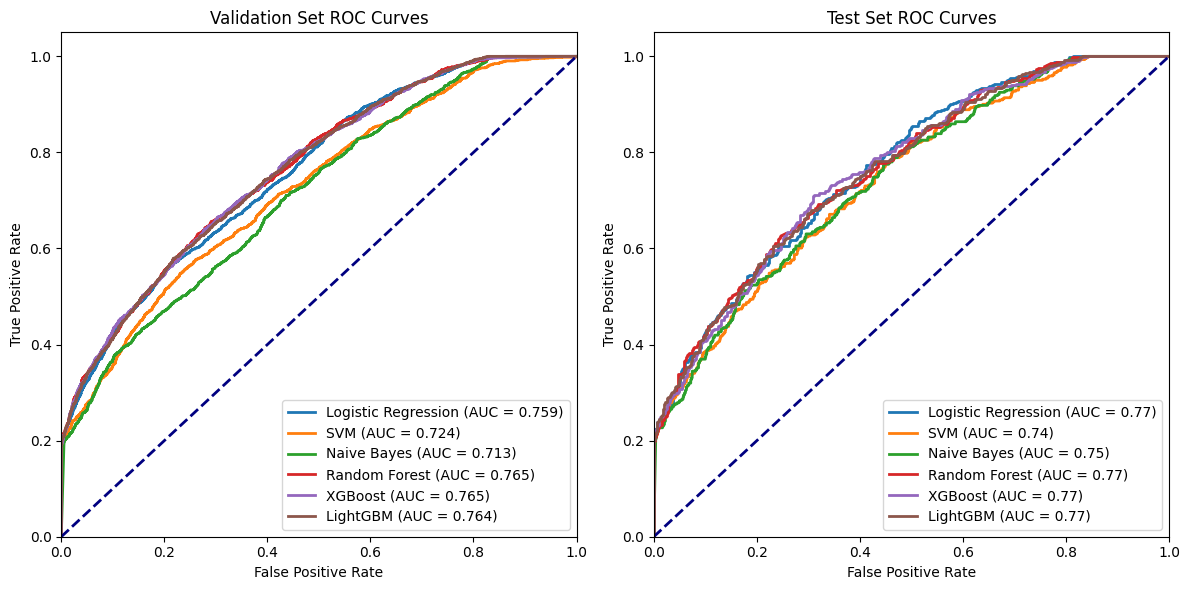

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

# 假设你已经有了数据集 X_train, X_test, y_train, y_test

# 定义模型及其最佳参数
models = {
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(C=10, gamma='auto', kernel='rbf', probability=True),
    "Naive Bayes": GaussianNB(var_smoothing=1e-5),
    "Random Forest": RandomForestClassifier(
        max_depth=10, max_features='sqrt', min_samples_leaf=1,
        min_samples_split=10, n_estimators=200
    ),
    "XGBoost": xgb.XGBClassifier(
        colsample_bytree=0.8, learning_rate=0.1, max_depth=3,
        n_estimators=100, subsample=0.8
    ),
    "LightGBM": lgb.LGBMClassifier(
        colsample_bytree=0.8, learning_rate=0.1, max_depth=5,
        n_estimators=100, num_leaves=31, subsample=0.8
    )
}

# 绘制验证集的 ROC 曲线
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # 左边图：验证集

for name, model in models.items():
    # 使用交叉验证获取验证集的预测概率
    y_pred_val = cross_val_predict(model, X_train, y_train, cv=5, method='predict_proba')[:, 1]
    fpr, tpr, _ = roc_curve(y_train, y_pred_val)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation Set ROC Curves')
plt.legend(loc="lower right")

# 绘制测试集的 ROC 曲线
plt.subplot(1, 2, 2)  # 右边图：测试集

for name, model in models.items():
    # 训练模型并在测试集上进行预测
    model.fit(X_train, y_train)
    y_pred_test = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_test)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Set ROC Curves')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

# 创新点 二次调参 在上面

# 模型融合

In [79]:
TARGET_NAME = 'Credit Default'
CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']
BASE_FEATURE_NAMES = data.columns.drop(TARGET_NAME).tolist()
NUM_FEATURE_NAMES = data.columns.drop(CAT_FEATURE_NAMES + [TARGET_NAME]).tolist()

In [81]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# 定义基模型
base_models = [
    ('XGB', XGBClassifier(random_state=42,colsample_bytree=0.8, learning_rate=0.1, max_depth=3,
        n_estimators=100, subsample=0.8)),  # KNN 回归
    ('RandomForestClassifier', RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=1,
        min_samples_split=10, n_estimators=200)),  
    ('lightgbm', LGBMClassifier(colsample_bytree=0.8, learning_rate=0.1, max_depth=5,
        n_estimators=100, num_leaves=31, subsample=0.8))  # 线性回归
]

# 定义元模型（XGBoost）
# meta_model = XGBClassifier(random_state=42,colsample_bytree=0.8, learning_rate=0.1, max_depth=3,
#         n_estimators=100, subsample=0.8)
meta_model = CatBoostClassifier(silent=True, random_state=21)
# 创建 Stacking 回归器
stacking_model = StackingClassifier(
    estimators=base_models,  # 基模型
    final_estimator=meta_model,  # 元模型
    cv=5,  # 交叉验证折数
    n_jobs=-1  # 使用所有 CPU 核心
)

# 训练 Stacking 模型
stacking_model.fit(X_train, y_train)

# 预测
y_test_pred = stacking_model.predict_proba(X_test)[:, 1]
y_pred_lr = stacking_model.predict(X_test)
# 输出结果
# print(f"Stacking 模型测试集 RMSE: {test_rmse:.4f}")
# 输出混淆矩阵
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

# 输出分类报告
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

print("AUC",roc_auc_score(y_test,y_test_pred))
# 打印 Stacking 模型的参数
print("Stacking 模型参数：")
print(stacking_model.get_params())

Confusion Matrix:
 [[920 139]
 [243 198]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.87      0.83      1059
           1       0.59      0.45      0.51       441

    accuracy                           0.75      1500
   macro avg       0.69      0.66      0.67      1500
weighted avg       0.73      0.75      0.73      1500

AUC 0.7626359955376549
Stacking 模型参数：
{'cv': 5, 'estimators': [('XGB', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_le

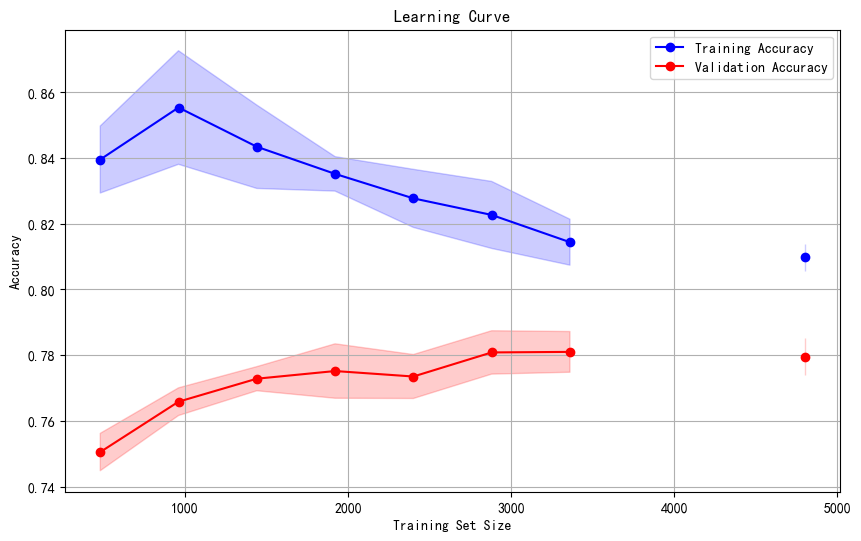

In [ ]:
# stacking_model 两条线离得有点远 过拟合了
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
# 获取学习曲线数据
train_sizes, train_scores, val_scores = learning_curve(
    stacking_model, X_train, y_train, cv=5, n_jobs=1, 
    train_sizes=np.linspace(0.1, 1.0, 10),  # 训练集大小范围
    scoring='accuracy'  # 使用准确率作为评分指标
)

# 计算平均值和标准差
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# 绘制学习曲线
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Accuracy', color='blue', marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_mean, label='Validation Accuracy', color='red', marker='o')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='red')

plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4328, number of negative: 4328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2987
[LightGBM] [Info] Number of data points in the train set: 8656, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

[I 2025-03-05 09:13:14,139] A new study created in memory with name: no-name-9cb09205-bdf8-47f8-b6ab-b0d56766131b
[I 2025-03-05 09:13:14,160] Trial 0 finished with value: 0.9107092598255438 and parameters: {'xgb': 0.8159884533545224, 'rf': 0.9998973284754815, 'lgb': 0.816457998369602}. Best is trial 0 with value: 0.9107092598255438.
[I 2025-03-05 09:13:14,175] Trial 1 finished with value: 0.9066267967514119 and parameters: {'xgb': 0.7557337313195371, 'rf': 0.9937014339047917, 'lgb': 0.5228007582225924}. Best is trial 0 with value: 0.9107092598255438.
[I 2025-03-05 09:13:14,191] Trial 2 finished with value: 0.9029049545409509 and parameters: {'xgb': 0.44059866668575953, 'rf': 0.2762085558540175, 'lgb': 0.23100497670005704}. Best is trial 0 with value: 0.9107092598255438.
[I 2025-03-05 09:13:14,204] Trial 3 finished with value: 0.9116175118986201 and parameters: {'xgb': 0.6643363328604632, 'rf': 0.8716642273692202, 'lgb': 0.7250456747041427}. Best is trial 3 with value: 0.911617511898620

最优权重： {'xgb': 0.0014989459170860425, 'rf': 0.012519559585956297, 'lgb': 0.87160404963155}
最优 AUC： 0.9298048152254502
测试集 AUC： 0.7575815973225929


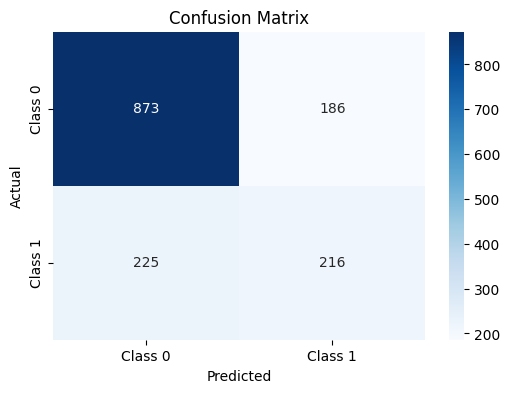

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.80      0.82      0.81      1059
     Class 1       0.54      0.49      0.51       441

    accuracy                           0.73      1500
   macro avg       0.67      0.66      0.66      1500
weighted avg       0.72      0.73      0.72      1500



In [82]:
# optuna 加权融合
import numpy as np
import optuna
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

# 准备数据
# data, target = make_classification(n_samples=2000, n_features=20, n_informative=12, n_redundant=4, n_classes=2)
# X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# 训练基模型
xgb = XGBClassifier(random_state=42, colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8)
rf = RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=1, min_samples_split=10, n_estimators=200)
lgb = LGBMClassifier(colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=31, subsample=0.8)

xgb.fit(X_train, y_train)
rf.fit(X_train, y_train)
lgb.fit(X_train, y_train)

# 获取基模型的预测概率
preds_train = {
    'xgb': xgb.predict_proba(X_train)[:, 1],
    'rf': rf.predict_proba(X_train)[:, 1],
    'lgb': lgb.predict_proba(X_train)[:, 1]
}

preds_test = {
    'xgb': xgb.predict_proba(X_test)[:, 1],
    'rf': rf.predict_proba(X_test)[:, 1],
    'lgb': lgb.predict_proba(X_test)[:, 1]
}

# 定义 Optuna 的目标函数
def objective(trial):
    # 定义权重范围
    weights = {
        'xgb': trial.suggest_float('xgb', 0, 1),
        'rf': trial.suggest_float('rf', 0, 1),
        'lgb': trial.suggest_float('lgb', 0, 1)
    }
    
    # 归一化权重
    total_weight = sum(weights.values())
    normalized_weights = {k: v / total_weight for k, v in weights.items()}
    
    # 计算加权平均预测
    weighted_pred = (
        normalized_weights['xgb'] * preds_train['xgb'] +
        normalized_weights['rf'] * preds_train['rf'] +
        normalized_weights['lgb'] * preds_train['lgb']
    )
    
    # 计算 AUC
    auc = roc_auc_score(y_train, weighted_pred)
    return auc

# 创建 Optuna 研究对象并优化
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# 获取最优权重
best_weights = study.best_params
print("最优权重：", best_weights)
print("最优 AUC：", study.best_value)

# 使用最优权重计算测试集的预测结果
best_weights_normalized = {k: v / sum(best_weights.values()) for k, v in best_weights.items()}
weighted_pred_test = (
    best_weights_normalized['xgb'] * preds_test['xgb'] +
    best_weights_normalized['rf'] * preds_test['rf'] +
    best_weights_normalized['lgb'] * preds_test['lgb']
)


# 计算测试集的 AUC
test_auc = roc_auc_score(y_test, weighted_pred_test)
print("测试集 AUC：", test_auc)

# 将预测概率转换为类别预测
y_pred = (weighted_pred_test >= 0.5).astype(int)

# 输出混淆矩阵
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 输出分类报告
report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'])
print("Classification Report:")
print(report)

In [ ]:
X_train.values

array([[ 1.99695538, -0.11095342, -0.2303985 , ...,  0.        ,
         0.        ,  1.        ],
       [-1.09456354, -0.11095342, -1.24901953, ...,  0.        ,
         0.        ,  1.        ],
       [-0.28437323, -0.11095342,  0.17704992, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.70449386, -0.11095342, -0.4341227 , ...,  0.        ,
         0.        ,  1.        ],
       [ 3.43364743, -0.11095342, -0.63784691, ...,  0.        ,
         0.        ,  1.        ],
       [-0.40875007, -0.11095342, -0.84157112, ...,  0.        ,
         0.        ,  1.        ]])

# 交叉验证

In [ ]:
from sklearn.model_selection import KFold
X_train1=X_train.values
y_train1=y_train.values

kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_preds = np.zeros(len(X_train1))
test_preds = np.zeros(len(X_test))

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train1)):
    X_fold_train, X_fold_val = X_train1[train_idx], X_train1[val_idx]
    y_fold_train, y_fold_val = y_train1[train_idx], y_train1[val_idx]

    # 训练基模型
    xgb.fit(X_fold_train, y_fold_train)
    rf.fit(X_fold_train, y_fold_train)
    lgb.fit(X_fold_train, y_fold_train)

    # 获取预测概率
    train_preds[val_idx] = (
        best_weights_normalized['xgb'] * xgb.predict_proba(X_fold_val)[:, 1] +
        best_weights_normalized['rf'] * rf.predict_proba(X_fold_val)[:, 1] +
        best_weights_normalized['lgb'] * lgb.predict_proba(X_fold_val)[:, 1]
    )

# 计算交叉验证的 AUC
cv_auc = roc_auc_score(y_train, train_preds)
print("交叉验证 AUC：", cv_auc)

[LightGBM] [Info] Number of positive: 1326, number of negative: 3474
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1852
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.276250 -> initscore=-0.963140
[LightGBM] [Info] Start training from score -0.963140
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

# 逻辑回归解释

         Current function value: 0.457313
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:         Credit Default   No. Observations:                 6000
Model:                          Logit   Df Residuals:                     5969
Method:                           MLE   Df Model:                           30
Date:                  周五, 28 2月 2025   Pseudo R-squ.:                  0.2271
Time:                        20:37:42   Log-Likelihood:                -2743.9
converged:                      False   LL-Null:                       -3550.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -0.0134        nan        nan        nan         nan         nan
Annual Inco

c:\UserFiles\Anaconda3\envs\hh\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


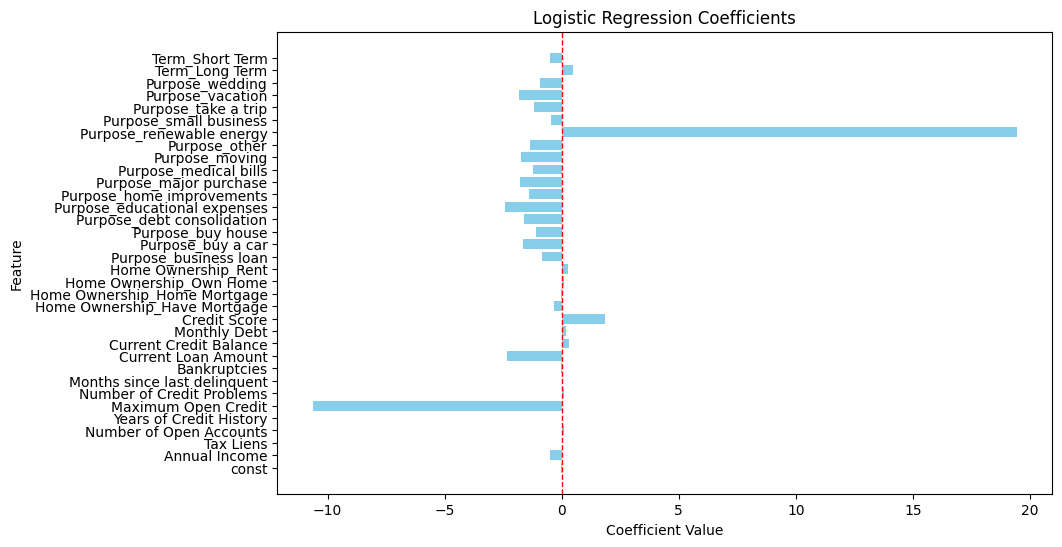

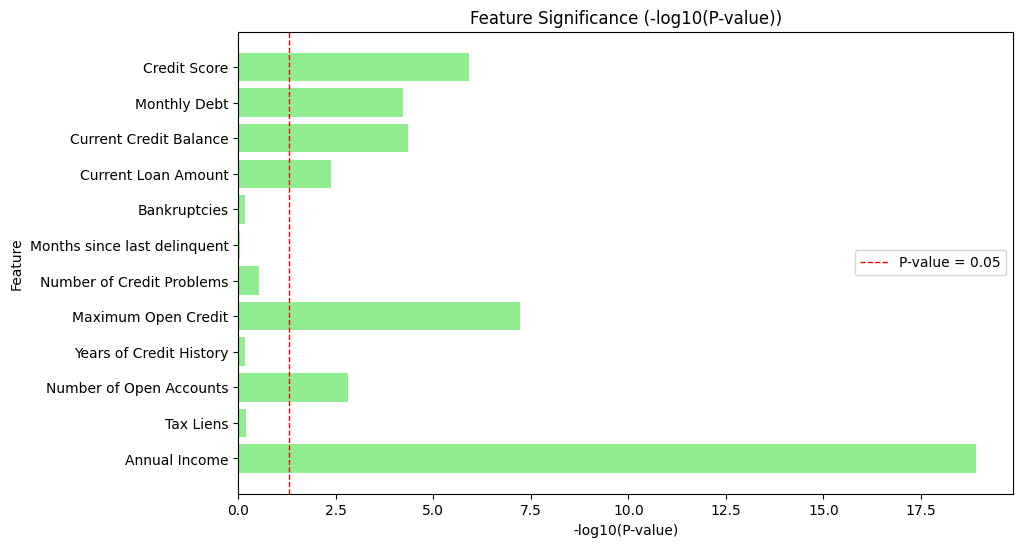

In [ ]:

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# 假设你已经有了数据集 X_train, y_train

# 添加常数项（截距）
X_train_const = sm.add_constant(X_train)

# 使用 statsmodels 拟合逻辑回归模型
logit_model = sm.Logit(y_train, X_train_const)
result = logit_model.fit()

# 输出模型摘要
print(result.summary())

# 提取系数和 p 值
params = result.params  # 系数
p_values = result.pvalues  # p 值

# 创建一个 DataFrame 来存储系数和 p 值
coef_df = pd.DataFrame({
    'Feature': X_train_const.columns,
    'Coefficient': params,
    'P-value': p_values
})

# 打印系数和 p 值
print(coef_df)

# 绘制显著性图（系数条形图）
plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='skyblue')
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Logistic Regression Coefficients')
plt.show()

# 绘制显著性图（p 值条形图）
plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'], -np.log10(coef_df['P-value']), color='lightgreen')
plt.axvline(x=-np.log10(0.05), color='red', linestyle='--', linewidth=1, label='P-value = 0.05')
plt.xlabel('-log10(P-value)')
plt.ylabel('Feature')
plt.title('Feature Significance (-log10(P-value))')
plt.legend()
plt.show()

# 逻辑回归结果

## 模型概览
- **因变量**: Credit Default
- **样本数**: 6000
- **伪 R 方 (Pseudo R-squ.)**: 0.2271
- **对数似然值 (Log-Likelihood)**: -2743.9
- **LL-Null**: -3550.1
- **LLR p-value**: 0.000

## 显著特征（p-value < 0.05）

| 特征名称                  | 系数 (Coefficient) | 标准误差 (Std Error) | P 值 (P-value) | 置信区间 (95%)         |
|---------------------------|--------------------|----------------------|----------------|------------------------|
| Annual Income             | -0.5053            | 0.056                | 0.000          | [-0.615, -0.396]       |
| Number of Open Accounts   | 0.1201             | 0.038                | 0.002          | [0.046, 0.194]         |
| Maximum Open Credit       | -10.6414           | 1.963                | 0.000          | [-14.490, -6.793]      |
| Current Loan Amount       | -2.3343            | 0.813                | 0.004          | [-3.928, -0.740]       |
| Current Credit Balance    | 0.2998             | 0.074                | 0.000          | [0.156, 0.444]         |
| Monthly Debt              | 0.1913             | 0.048                | 0.000          | [0.098, 0.285]         |
| Credit Score              | 1.8592             | 0.383                | 0.000          | [1.109, 2.610]         |

## 不显著特征（p-value ≥ 0.05）

| 特征名称                  | 系数 (Coefficient) | 标准误差 (Std Error) | P 值 (P-value) | 置信区间 (95%)         |
|---------------------------|--------------------|----------------------|----------------|------------------------|
| Tax Liens                 | 0.0257             | 0.054                | 0.634          | [-0.080, 0.132]        |
| Years of Credit History   | 0.0144             | 0.036                | 0.688          | [-0.056, 0.085]        |
| Number of Credit Problems | 0.0834             | 0.080                | 0.298          | [-0.074, 0.240]        |
| Months since last delinquent | -0.0038        | 0.033                | 0.908          | [-0.069, 0.061]        |
| Bankruptcies              | -0.0269            | 0.064                | 0.676          | [-0.153, 0.099]        |
| Home Ownership_Have Mortgage | -0.3472       | 2.77e+06             | 1.000          | [-5.43e+06, 5.43e+06]  |
| Home Ownership_Home Mortgage | -0.0479       | 2.69e+06             | 1.000          | [-5.27e+06, 5.27e+06]  |
| Home Ownership_Own Home   | 0.1088             | 2.71e+06             | 1.000          | [-5.31e+06, 5.31e+06]  |
| Home Ownership_Rent       | 0.2730             | 2.83e+06             | 1.000          | [-5.55e+06, 5.55e+06]  |
| Purpose_business loan     | -0.8357            | 3.64e+06             | 1.000          | [-7.14e+06, 7.14e+06]  |
| Purpose_buy a car         | -1.6371            | 3.64e+06             | 1.000          | [-7.14e+06, 7.14e+06]  |
| Purpose_buy house         | -1.0777            | 3.64e+06             | 1.000          | [-7.14e+06, 7.14e+06]  |
| Purpose_debt consolidation | -1.6034           | 3.64e+06             | 1.000          | [-7.14e+06, 7.14e+06]  |
| Purpose_educational expenses | -2.4262         | 3.64e+06             | 1.000          | [-7.14e+06, 7.14e+06]  |
| Purpose_home improvements | -1.3765            | 3.64e+06             | 1.000          | [-7.14e+06, 7.14e+06]  |
| Purpose_major purchase    | -1.7681            | 3.64e+06             | 1.000          | [-7.14e+06, 7.14e+06]  |
| Purpose_medical bills     | -1.2326            | 3.64e+06             | 1.000          | [-7.14e+06, 7.14e+06]  |
| Purpose_moving            | -1.7331            | 3.64e+06             | 1.000          | [-7.14e+06, 7.14e+06]  |
| Purpose_other             | -1.3692            | 3.64e+06             | 1.000          | [-7.14e+06, 7.14e+06]  |
| Purpose_renewable energy  | 19.4472            | 3.64e+06             | 1.000          | [-7.14e+06, 7.14e+06]  |
| Purpose_small business    | -0.4564            | 3.64e+06             | 1.000          | [-7.14e+06, 7.14e+06]  |
| Purpose_take a trip       | -1.1906            | 3.64e+06             | 1.000          | [-7.14e+06, 7.14e+06]  |
| Purpose_vacation          | -1.8112            | 3.64e+06             | 1.000          | [-7.14e+06, 7.14e+06]  |
| Purpose_wedding           | -0.9428            | 3.64e+06             | 1.000          | [-7.14e+06, 7.14e+06]  |
| Term_Long Term            | 0.4766             | 3.19e+06             | 1.000          | [-6.24e+06, 6.24e+06]  |
| Term_Short Term           | -0.4900            | 3.19e+06             | 1.000          | [-6.24e+06, 6.24e+06]  |

# 机器学习可解释性分析

原则上挑选表现最好的模型，对其利用shap和pdpbox库进行可解释性分析

这里我们选取lightgbm模型进行可解释性分析，虽然他不是表现最好的，但是他计算速度最快，你可以说自己其实是对随机森林解释的，没有什么区别

In [ ]:
# shap解释需要计算shap值，才可以后续可视化
import shap
import lightgbm as lgb

# 使用最佳参数重新训练一个新的 LightGBM 模型
best_params = {'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 63}
lgb_best = lgb.LGBMClassifier(**best_params)
lgb_best.fit(X_train, y_train)

# 使用 shap 进行解释
# 创建一个 SHAP 解释器，使用训练好的 LightGBM 模型
explainer = shap.Explainer(lgb_best)

# 计算 SHAP 值，使用训练集
shap_values = explainer.shap_values(X_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1672, number of negative: 4328
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1872
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.278667 -> initscore=-0.951085
[LightGBM] [Info] Start training from score -0.951085


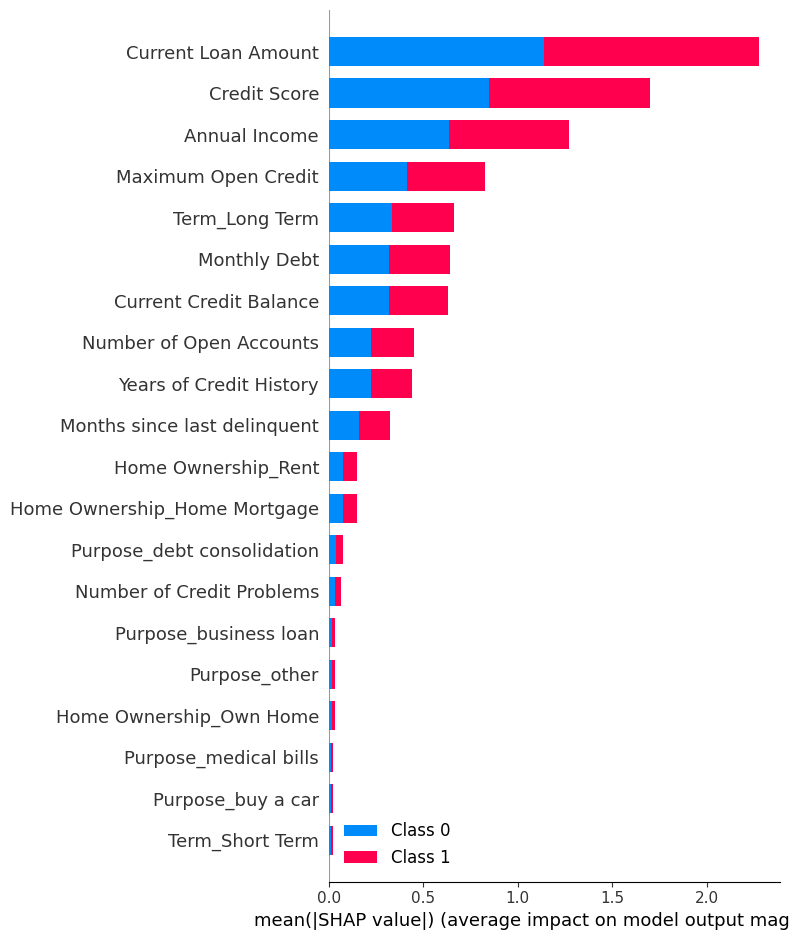

In [ ]:
# 可视化所有类别的SHAP 汇总图
shap.summary_plot(shap_values, X_train)

In [ ]:
print(shap_values)


[array([[ 1.55799244,  0.00368535, -0.02368476, ...,  0.        ,
         0.19433849,  0.00830191],
       [-0.69389358,  0.00291101,  0.17686268, ...,  0.        ,
         0.1505778 ,  0.00558457],
       [-0.28636517,  0.0041024 , -0.25040003, ...,  0.        ,
         0.14224376,  0.00990456],
       ...,
       [-0.45826397,  0.00349765,  0.08203181, ...,  0.        ,
         0.34094017,  0.00514992],
       [ 1.82067557,  0.00329601,  0.30856972, ...,  0.        ,
         0.13757624,  0.00532551],
       [-0.5791347 ,  0.00425474,  0.29286842, ...,  0.        ,
         0.38374936,  0.00532875]]), array([[-1.55799244, -0.00368535,  0.02368476, ...,  0.        ,
        -0.19433849, -0.00830191],
       [ 0.69389358, -0.00291101, -0.17686268, ...,  0.        ,
        -0.1505778 , -0.00558457],
       [ 0.28636517, -0.0041024 ,  0.25040003, ...,  0.        ,
        -0.14224376, -0.00990456],
       ...,
       [ 0.45826397, -0.00349765, -0.08203181, ...,  0.        ,
        

In [ ]:
print("X_train:")
print(X_train)

X_train:
      Annual Income  Tax Liens  Number of Open Accounts  \
4664       1.996955  -0.110953                -0.230398   
4411      -1.094564  -0.110953                -1.249020   
7448      -0.284373  -0.110953                 0.177050   
1919       0.221604  -0.110953                 0.991947   
1298       1.337686  -0.110953                 1.603119   
...             ...        ...                      ...   
5191      -0.408750  -0.110953                -1.249020   
5226       3.904931  -0.110953                -0.230398   
5390      -0.704494  -0.110953                -0.434123   
860        3.433647  -0.110953                -0.637847   
7270      -0.408750  -0.110953                -0.841571   

      Years of Credit History  Maximum Open Credit  Number of Credit Problems  \
4664                 0.281551            -0.028928                  -0.340979   
4411                -0.811970            -0.055914                  -0.340979   
7448                 0.863815          

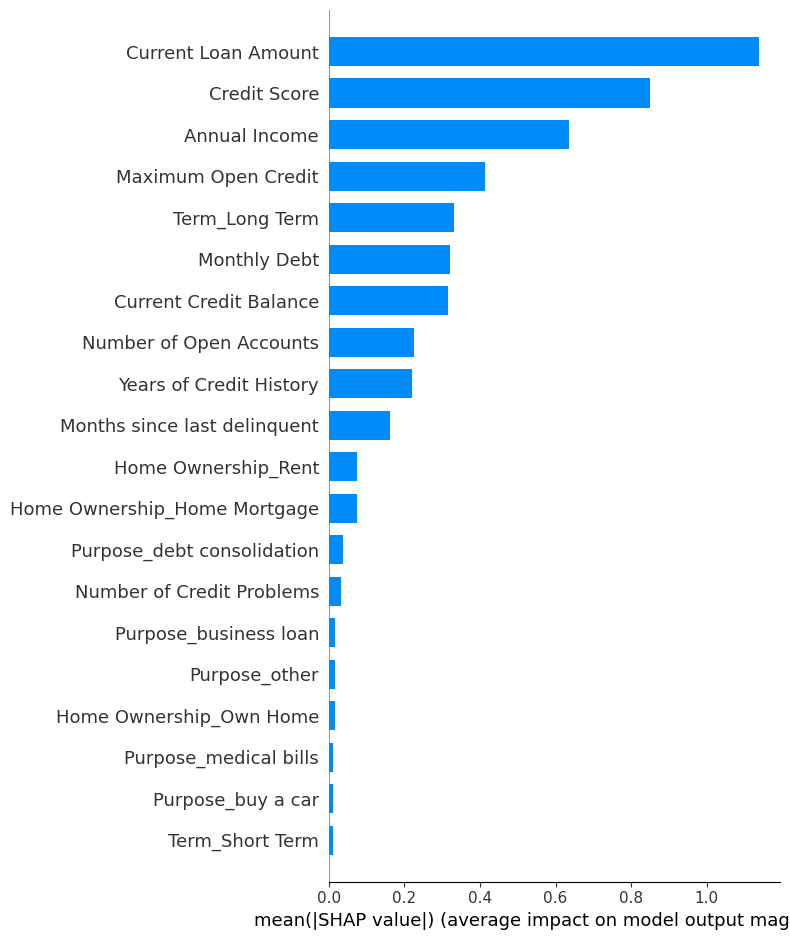

In [ ]:
# SHAP 汇总图设置为条形图，可以显示特征重要性
shap.summary_plot(shap_values[1], X_train, plot_type="bar")

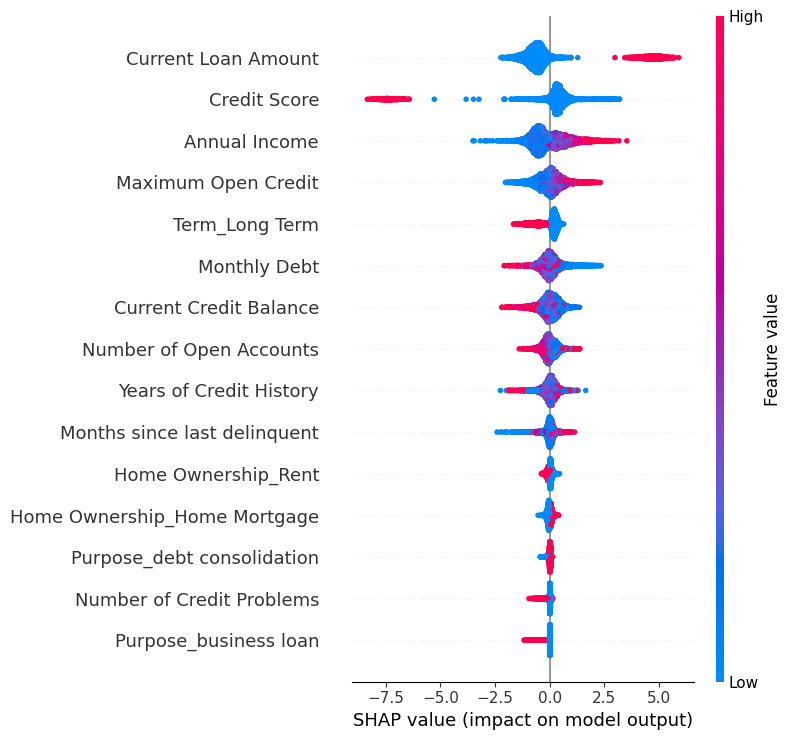

In [ ]:
# SHAP 汇总图默认设置为点图，可以反应特征的重要性和影响方向  0不违约 1违约？
shap.summary_plot(shap_values[0], X_train,plot_type="dot", max_display=15)

In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1500 entries, 970 to 2669
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 1500 non-null   float64
 1   Tax Liens                     1500 non-null   float64
 2   Number of Open Accounts       1500 non-null   float64
 3   Years of Credit History       1500 non-null   float64
 4   Maximum Open Credit           1500 non-null   float64
 5   Number of Credit Problems     1500 non-null   float64
 6   Months since last delinquent  1500 non-null   float64
 7   Bankruptcies                  1500 non-null   float64
 8   Current Loan Amount           1500 non-null   float64
 9   Current Credit Balance        1500 non-null   float64
 10  Monthly Debt                  1500 non-null   float64
 11  Credit Score                  1500 non-null   float64
 12  Home Ownership_Have Mortgage  1500 non-null   float64
 13  Home O

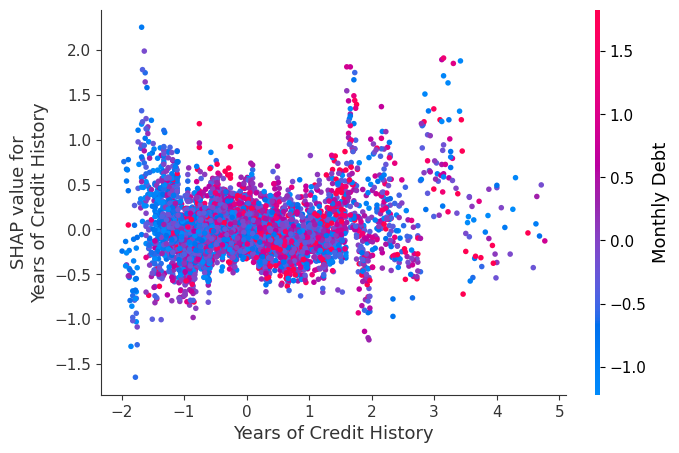

In [ ]:
# 同样的交互效应，也要在意数据的分布来优化可视化的图形
shap.dependence_plot('Years of Credit History', shap_values[1], X_train, interaction_index="Monthly Debt")
# shap.dependence_plot('Tax Liens', shap_values[1], X_train, interaction_index="Annual Income")

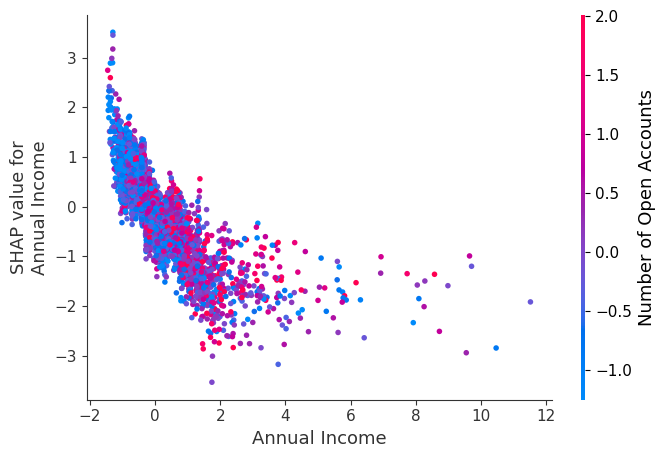

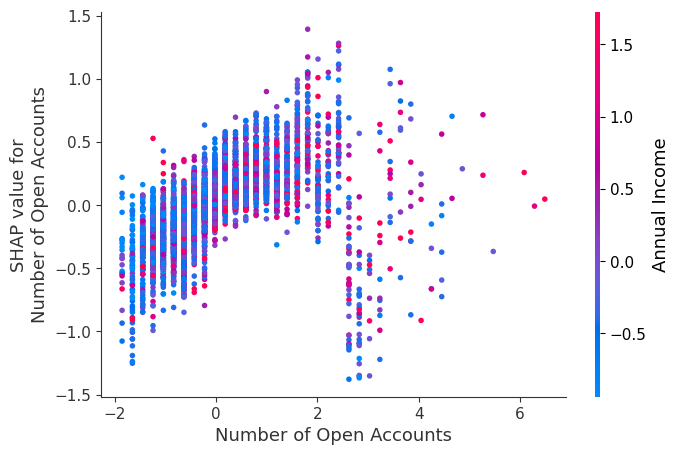

In [ ]:
# 同样的交互效应，也要在意数据的分布来优化可视化的图形
shap.dependence_plot('Annual Income', shap_values[1], X_train, interaction_index="Number of Open Accounts")
shap.dependence_plot('Number of Open Accounts', shap_values[1], X_train, interaction_index="Annual Income")

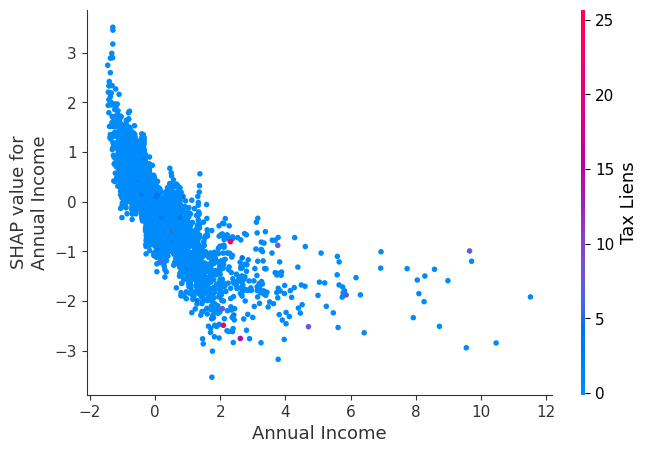

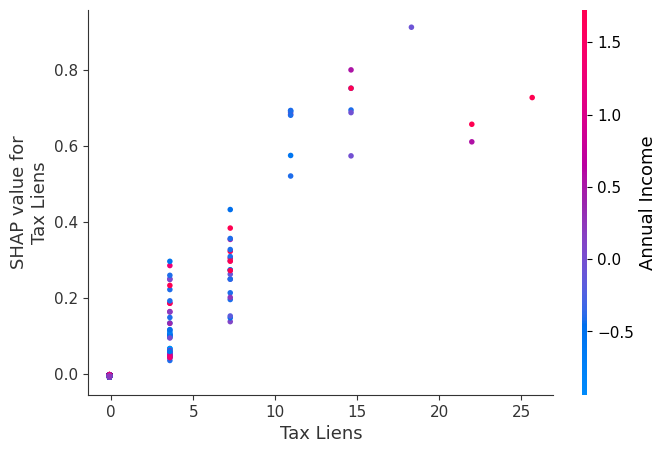

In [ ]:
# 同样的交互效应，也要在意数据的分布来优化可视化的图形
shap.dependence_plot('Annual Income', shap_values[1], X_train, interaction_index="Tax Liens")
shap.dependence_plot('Tax Liens', shap_values[1], X_train, interaction_index="Annual Income")

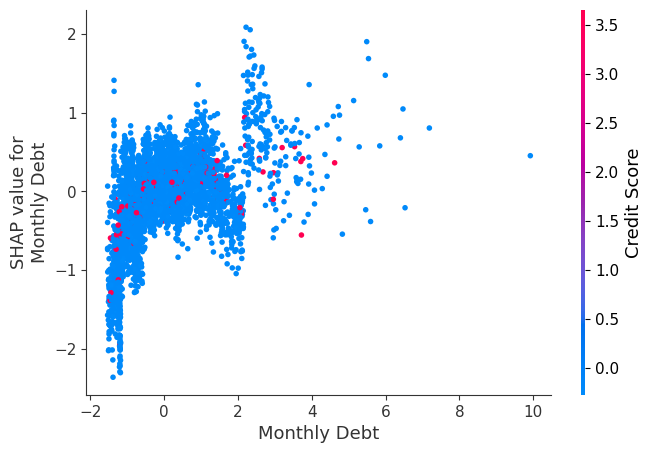

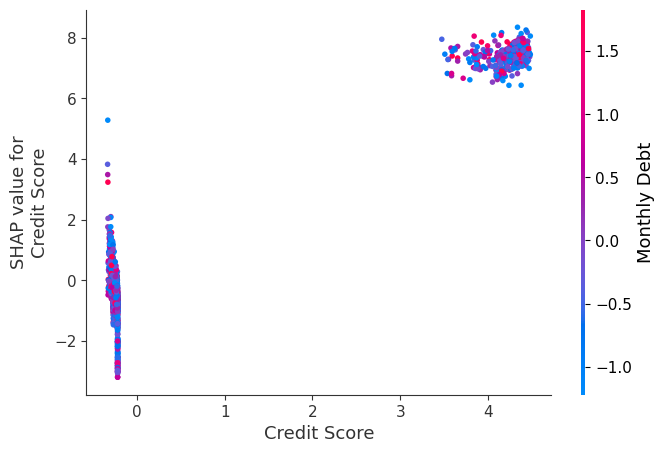

In [ ]:
# 同样的交互效应，也要在意数据的分布来优化可视化的图形
shap.dependence_plot('Monthly Debt', shap_values[1], X_train, interaction_index="Credit Score")
shap.dependence_plot('Credit Score', shap_values[1], X_train, interaction_index="Monthly Debt")

In [ ]:
# 绘制交互效应热力图，这个要计算很久
shap_interaction_values = explainer.shap_interaction_values(X_train)

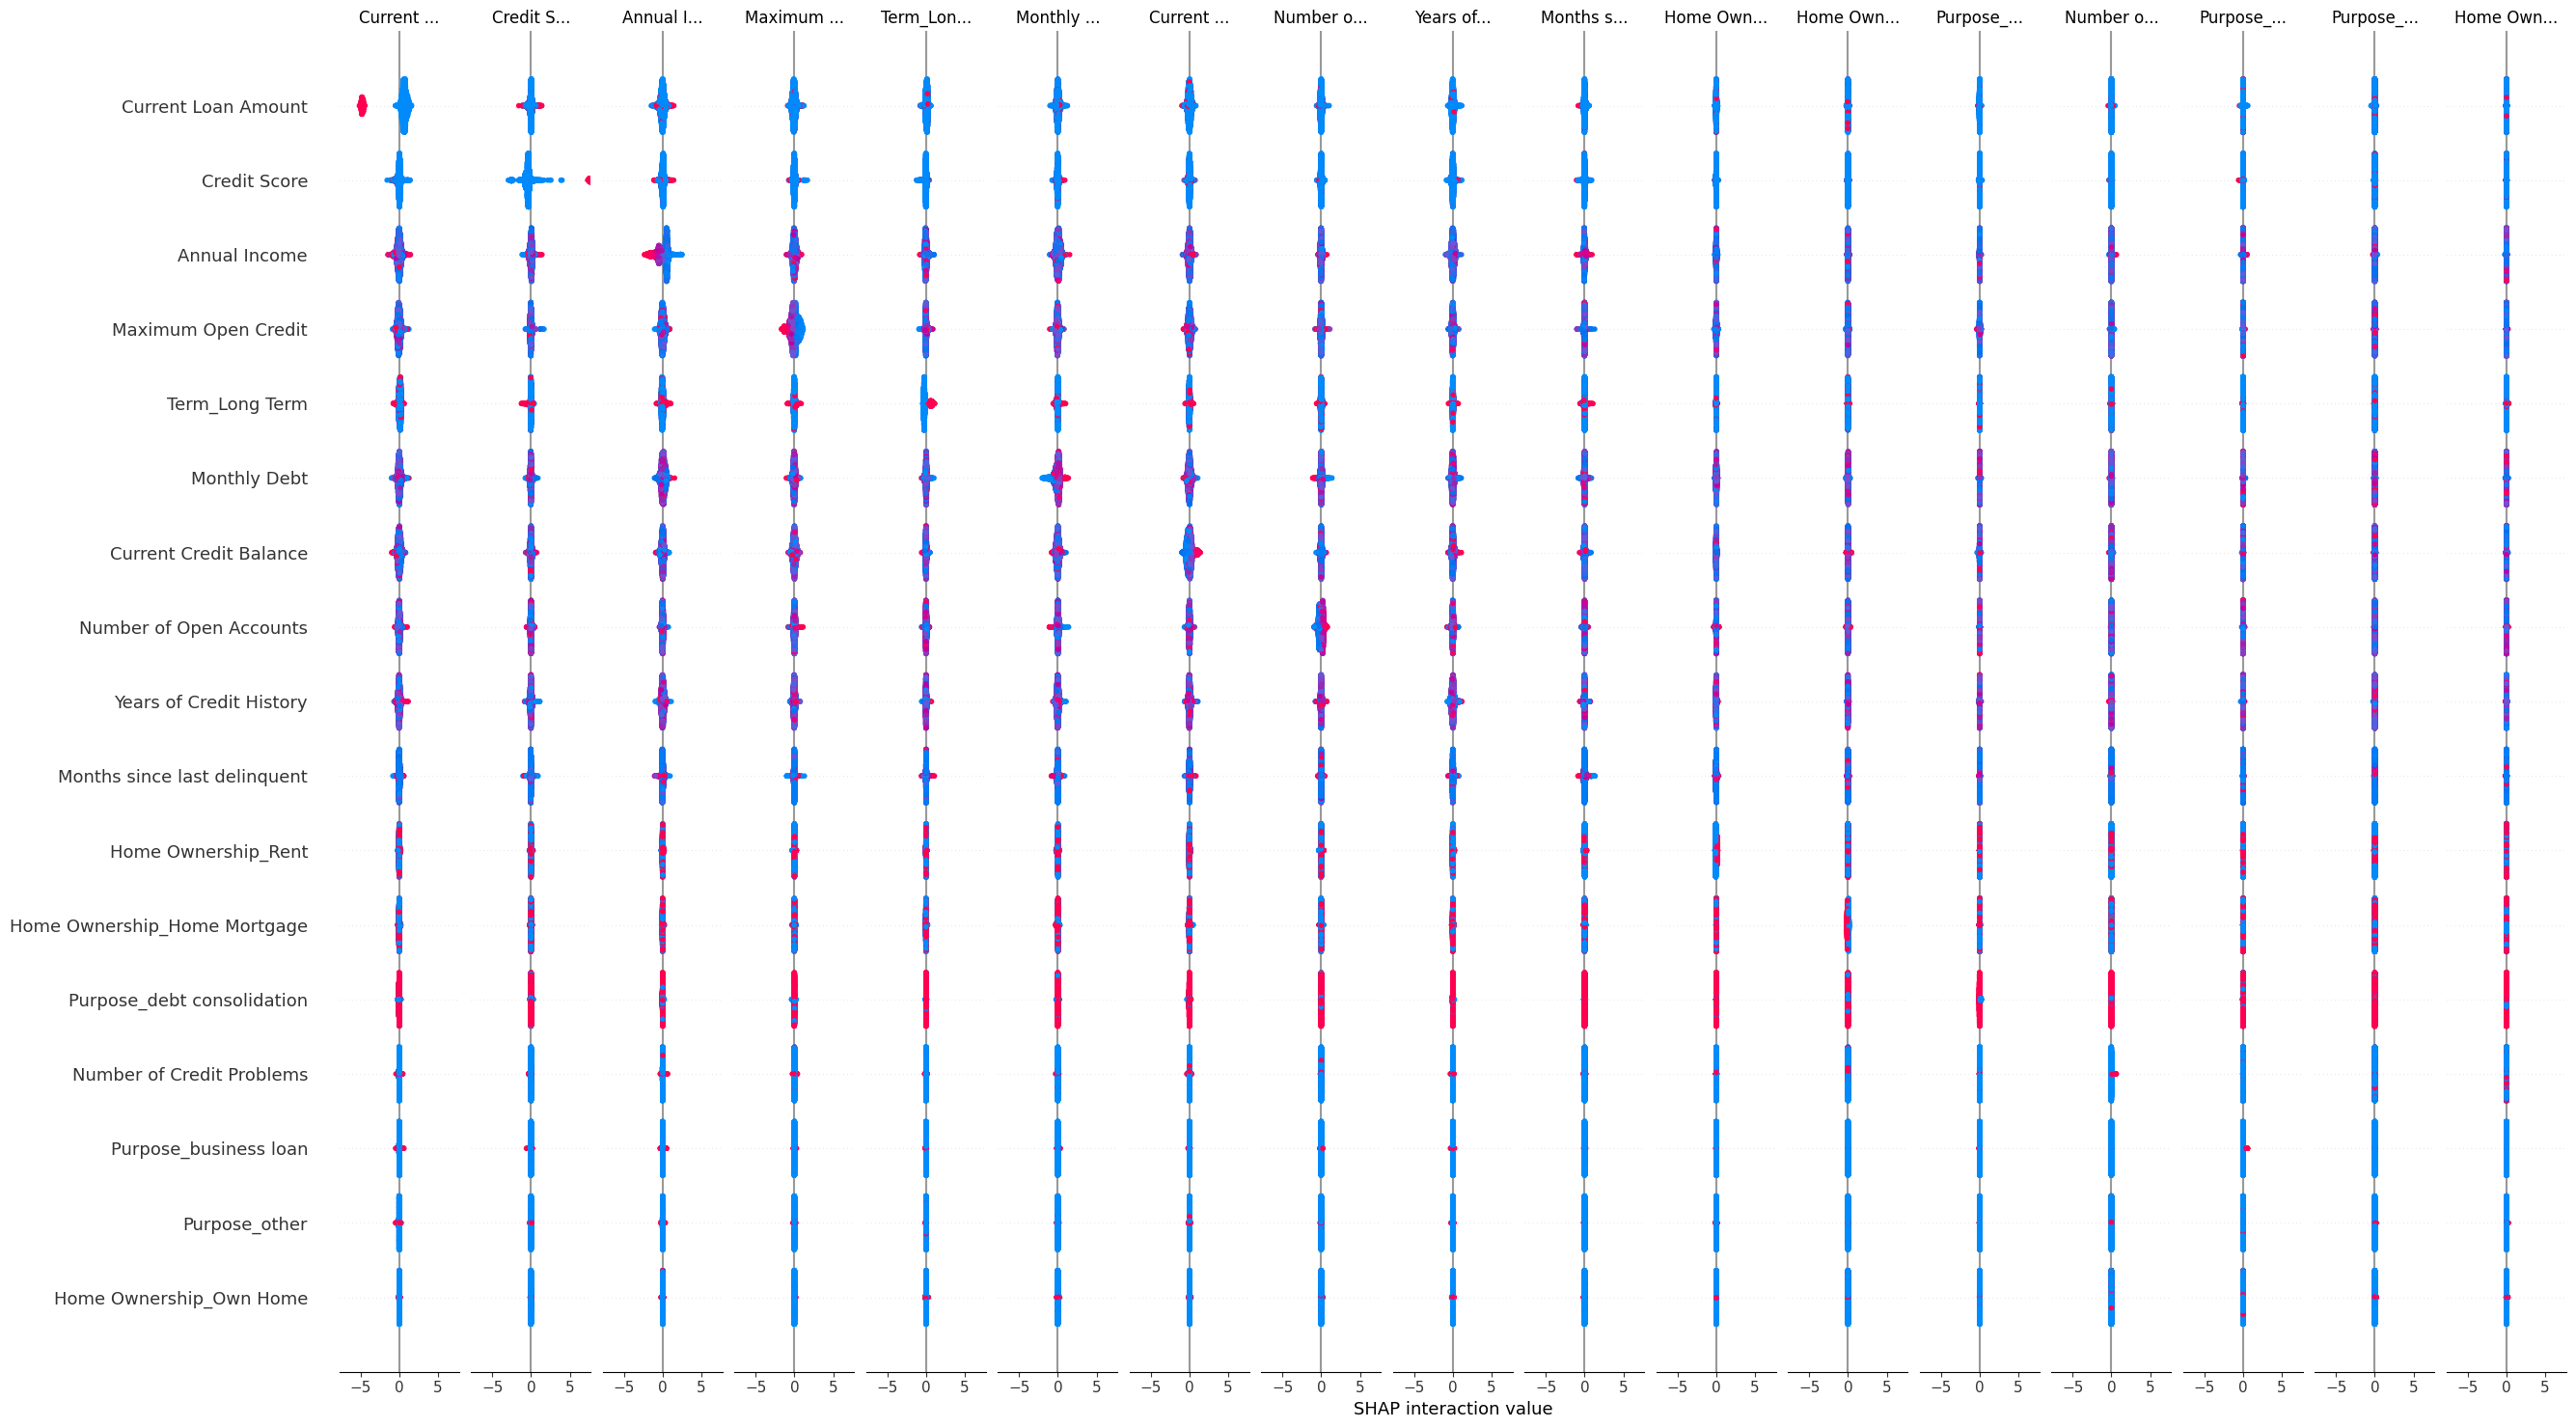

In [ ]:
# shap的交互是比较复杂的协同关系，并不是简单的相乘
# 可视化交互效应，max_display这个参数可以控制显示的特征数量，这个特征的顺序是重要度顺序
shap.summary_plot(shap_interaction_values, X_train, max_display=17)

# 如果分布在0附近，说明这个特征交互对模型的影响不大
# 如果分布在两端，说明这个特征交互对模型的影响很大
# 这个要运行很久

## 查看拟合情况